<a href="https://colab.research.google.com/github/sthamamta/Transfer-Learning-VGG/blob/main/VGG16_V4(Improved_Accuracy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
from sklearn import metrics
pd.options.display.max_colwidth = 600

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

plt.rcParams.update(params)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.models import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils


In [ ]:
BATCH_SIZE = 16
EPOCHS = 160
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
# Split training dataset in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [ ]:
# Transforming target variable/labels into one hot encoded form
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [ ]:

from skimage.transform import resize
from skimage import data

X_train = np.array([resize(x, (48,48)) for x in X_train])

# numpy.array(Image.fromarray(arr).resize())
X_val = np.array([resize(x, (48,48)) for x in X_val])
X_test = np.array([resize(x, (48,48)) for x in X_test])

In [ ]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [ ]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [ ]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [ ]:

train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [ ]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/160
2656/2656 [==============================] - 59s 6ms/step - loss: 0.3602 - accuracy: 0.2265 - val_loss: 0.2329 - val_accuracy: 0.4790
Epoch 2/160
2656/2656 [==============================] - 16s 6ms/step - loss: 0.2478 - accuracy: 0.4298 - val_loss: 0.2121 - val_accuracy: 0.5290
Epoch 3/160
2656/2656 [==============================] - 16s 6ms/step - loss: 0.2295 - accuracy: 0.4813 - val_loss: 0.2009 - val_accuracy: 0.5542
Epoch 4/160
2656/2656 [==============================] - 16s 6ms/step - loss: 0.2192 - accuracy: 0.5098 - val_loss: 0.1937 - val_accuracy: 0.5716
Epoch 5/160
2656/2656 [==============================] - 16s 6ms/step - loss: 0.2100 - accuracy: 0.5323 - val_loss: 0.1882 - val_accuracy: 0.5856
Epoch 6/160
2656/2656 [==============================] - 16s 6ms/step - loss: 0.2046 - accuracy: 0.5453 - val_loss: 0.1840 - val_accuracy: 0.5903
Epoch 7/160
2656/2656 [==============================] - 16s 6ms/step - loss: 0.2012 - accuracy: 0.5540 - val_loss: 0.1805 -

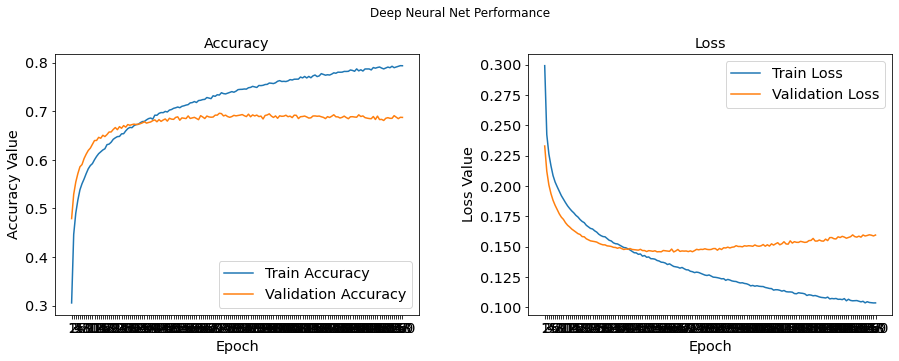

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
predictions = model.predict(X_test/255.)

In [ ]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [ ]:

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels),4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels,average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels,average='weighted'),4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels,average='weighted'),4))
                        

In [ ]:

get_metrics(true_labels=y_test,  predicted_labels=predictions)

Accuracy: 0.6878
Precision: 0.6868
Recall: 0.6878
F1 Score: 0.6863


In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
 !ls /content/drive/My\ Drive/ML_models

example  vggmodel_4.h5	vggmodel.h5  vggmodel_v2.h5


In [ ]:
model.save('/content/drive/My Drive/ML_models/vggmodel_v4.h5')

In [ ]:
 !ls /content/drive/My\ Drive/ML_models